<h1 style="text-align:center;">
  <span style="color:#0A66C2; font-weight:700;">Naukri.com</span>
  Job Listings Scraper (No Login)
</h1>


In [19]:
pip install selenium webdriver-manager pandas

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Environment Setup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import time
from urllib.parse import quote

In [ ]:
# Driver Setup

def create_driver() -> webdriver.Chrome:
    options = Options()
    options.add_argument("--start-maximized")
    options.add_argument("--disable-notifications")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )
    return driver

In [14]:
# Open Search Page/Tab

def open_search_page(driver: webdriver.Chrome, title: str, location: str) -> None:
    title = quote(title)
    location = quote(location)

    url = f"https://www.naukri.com/{title}-jobs-in-{location}?jobAge=1"
    driver.get(url)


    WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.TAG_NAME, "body"))
    )

    time.sleep(6)

In [15]:
# Safe Text Helper

def safe_text(parent, selector: str):
    try:
        return parent.find_element(By.CSS_SELECTOR, selector).text.strip()
    except:
        return None

In [17]:
def scrape_jobs(driver: webdriver.Chrome):
    cards = driver.find_elements(By.CSS_SELECTOR, "div.srp-jobtuple-wrapper")
    data = []

    print(f"DEBUG: Found {len(cards)} job cards")

    for card in cards:
        title = safe_text(card, "a.title")
        company = safe_text(card, "a.comp-name")
        location = safe_text(card, "span.locWdth")
        experience = safe_text(card, "span.expwdth")
        posted = safe_text(card, "span.job-post-day")

        try:
            link = card.find_element(By.CSS_SELECTOR, "a.title").get_attribute("href")
        except:
            link = None

        if not title:
            continue

        data.append([
            title,
            company,
            location,
            experience,
            posted,
            link
        ])

    return data

In [18]:
# Main Pipeline

def run() -> pd.DataFrame:
    driver = create_driver()

    try:
        open_search_page(driver, JOB_TITLE, LOCATION)
# to take ss
        driver.save_screenshot("naukri_loaded.png")

        data = scrape_jobs(driver)
    finally:
        driver.quit()

    df = pd.DataFrame(
        data,
        columns=["Job Title", "Company", "Location", "Experience", "Posted", "Link"]
    )

    df.drop_duplicates(inplace=True)
    df.to_csv(OUTPUT_FILE, index=False)

    print(f"Scraped {len(df)} jobs")
    print(f"Saved to {OUTPUT_FILE}")

    return df

In [53]:
# Configuration
# If anyone is watching this project
# let me tell you, you can put the Job Role and Location here

JOB_TITLE = "Sales"
LOCATION = "Bangalore"
OUTPUT_FILE = "naukri_jobs_last_24_hours.csv"

In [54]:
# Execute
if __name__ == "__main__":
    df = run()
    print(df.head())

DEBUG: Found 20 job cards
Scraped 20 jobs
Saved to naukri_jobs_last_24_hours.csv
                                           Job Title         Company  \
0  Relationship Manager | Sales- Fresher Role - B...        NoBroker   
1   NR Relationship Manager & Inside Sales Executive        NoBroker   
2                          Sales & Marketing Manager  Sales Partners   
3           Sales Development Representative (Email)          Tracxn   
4                  Associate General Manager - Sales        Livspace   

                   Location Experience         Posted  \
0  Bengaluru(HSR Layout +6)    0-1 Yrs     1 week ago   
1       Bengaluru(Sarjapur)    0-1 Yrs     2 days ago   
2      Mangaluru, Bengaluru    0-5 Yrs     1 week ago   
3                 Bengaluru    0-3 Yrs       Just now   
4                 Bengaluru   6-11 Yrs  Few hours ago   

                                                Link  
0  https://www.naukri.com/job-listings-relationsh...  
1  https://www.naukri.com/job-lis

In [55]:
df.head()

,Job Title,Company,Location,Experience,Posted,Link
0,Relationship Manager | Sales- Fresher Role - B...,NoBroker,Bengaluru(HSR Layout +6),0-1 Yrs,1 week ago,https://www.naukri.com/job-listings-relationsh...
1,NR Relationship Manager & Inside Sales Executive,NoBroker,Bengaluru(Sarjapur),0-1 Yrs,2 days ago,https://www.naukri.com/job-listings-nr-relatio...
2,Sales & Marketing Manager,Sales Partners,"Mangaluru, Bengaluru",0-5 Yrs,1 week ago,https://www.naukri.com/job-listings-sales-mark...
3,Sales Development Representative (Email),Tracxn,Bengaluru,0-3 Yrs,Just now,https://www.naukri.com/job-listings-sales-deve...
4,Associate General Manager - Sales,Livspace,Bengaluru,6-11 Yrs,Few hours ago,https://www.naukri.com/job-listings-associate-...


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def experience_to_numeric(exp):
    try:
        exp = exp.replace(" Yrs", "").strip()
        low, high = exp.split("-")
        return (int(low) + int(high)) / 2
    except:
        return np.nan

df["Experience_Num"] = df["Experience"].apply(experience_to_numeric)


In [57]:
df[["Experience", "Experience_Num"]].head()

,Experience,Experience_Num
0,0-1 Yrs,0.5
1,0-1 Yrs,0.5
2,0-5 Yrs,2.5
3,0-3 Yrs,1.5
4,6-11 Yrs,8.5


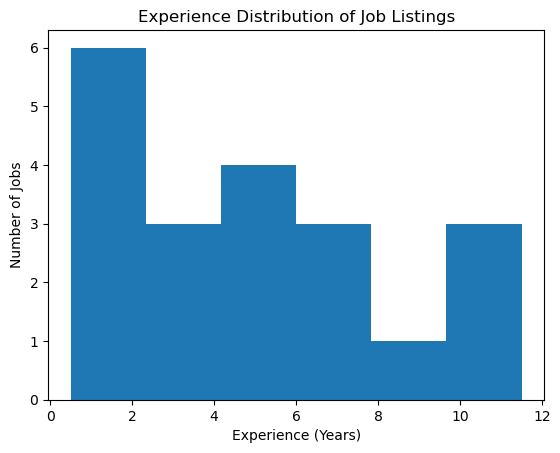

In [58]:
plt.figure()
plt.hist(df["Experience_Num"].dropna(), bins=6)
plt.xlabel("Experience (Years)")
plt.ylabel("Number of Jobs")
plt.title("Experience Distribution of Job Listings")
plt.show()


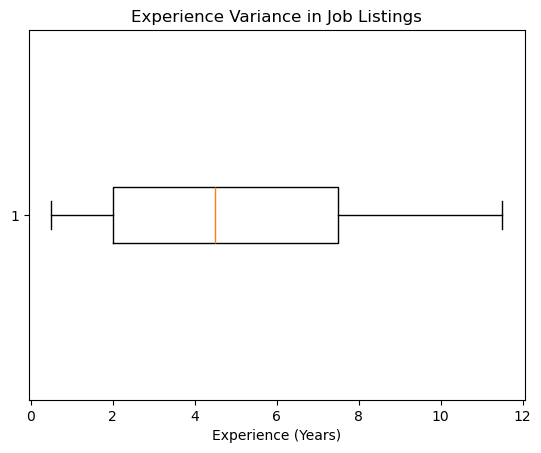

In [59]:
plt.figure()
plt.boxplot(df["Experience_Num"].dropna(), vert=False)
plt.xlabel("Experience (Years)")
plt.title("Experience Variance in Job Listings")
plt.show()